# KH Temp Fire Modeling Notebook - Random Forest, Extra Trees

In [1]:
# Import libraries.
import boto3
import io
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import plot_confusion_matrix, recall_score, accuracy_score, f1_score, make_scorer, precision_score
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.model_selection import validation_curve
from sklearn.preprocessing import StandardScaler

s3 = boto3.client('s3')

%config InlineBackend.figure_format = 'retina'

In [2]:
# Pull in cleaned and combined data from AWS 
noaa_on_fire = noaa_on_fire = pd.read_csv('s3://git-to-amazon-s3-outputbucket-rorni8oehk4l/soulclimberchick/meteorology-fire-impact/data-files/mfi_df_yr_trail.csv')
noaa_on_fire = pd.get_dummies(noaa_on_fire, columns=['state', 'month'], drop_first= True)

noaa_on_fire_btstrp = pd.concat([noaa_on_fire, 
                                 noaa_on_fire[noaa_on_fire['fire_size_class'] == 'C'].sample(n = 100000, replace = True, random_state=11),
                                 noaa_on_fire[noaa_on_fire['fire_size_class'] == 'D'].sample(n = 100000, replace = True, random_state=11),
                                 noaa_on_fire[noaa_on_fire['fire_size_class'] == 'E'].sample(n = 100000, replace = True, random_state=11),
                                 noaa_on_fire[noaa_on_fire['fire_size_class'] == 'F'].sample(n = 100000, replace = True, random_state=11),
                                 noaa_on_fire[noaa_on_fire['fire_size_class'] == 'G'].sample(n = 100000, replace = True, random_state=11)], axis = 0)

In [3]:
# Set up X and y variables, and bootstrap data

X_vars = ['state_CA', 'state_CO', 'state_ID',
       'state_MT', 'state_NM', 'state_NV', 'state_OR', 'state_UT', 'state_WA',
       'state_WY', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12','tavg_t12m',
       'tavg_t9m', 'tavg_t6m', 'tavg_t3m', 'pcp_t12m', 'pcp_t9m', 'pcp_t6m',
       'pcp_t3m', 'pmdi_t12m', 'pmdi_t9m', 'pmdi_t6m', 'pmdi_t3m', 'pdsi_t12m',
       'pdsi_t9m', 'pdsi_t6m', 'pdsi_t3m', 'zndx', 'cdd', 'hdd']

noaa_on_fire_btstrp = noaa_on_fire.dropna(subset = X_vars)


X = noaa_on_fire_btstrp[X_vars]
y = noaa_on_fire_btstrp['fire_size_class']

In [4]:
# Train Test Split and scale data
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify = y)

stan = StandardScaler()
X_train = stan.fit_transform(X_train)
X_test = stan.transform(X_test)

In [5]:
# What is the accuracy of our baseline model?
y.value_counts(normalize=True)

A    0.613502
B    0.290010
C    0.055196
D    0.015331
E    0.011383
F    0.009211
G    0.005367
Name: fire_size_class, dtype: float64

In [6]:
# Instantiate simple RandomForestClassifier and ExtraTreesClassifier objects.
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
et = ExtraTreesClassifier(n_estimators=100, n_jobs=-1)

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [7]:
# Fit and score on the training data.
cross_val_score(rf, X_train, y_train, cv=5).mean()

0.6205730399059611

In [8]:
# Fit and score on the training data.
cross_val_score(et, X_train, y_train, cv=5).mean()

0.620948813583642

In [9]:
# Score on the testing data.
rf.score(X_test, y_test)

0.6205431074043776

In [12]:
# Calculate Recall Score on random forest
recall_score(y_train, rf.predict(X_train), average = 'weighted')

0.6266984576707436

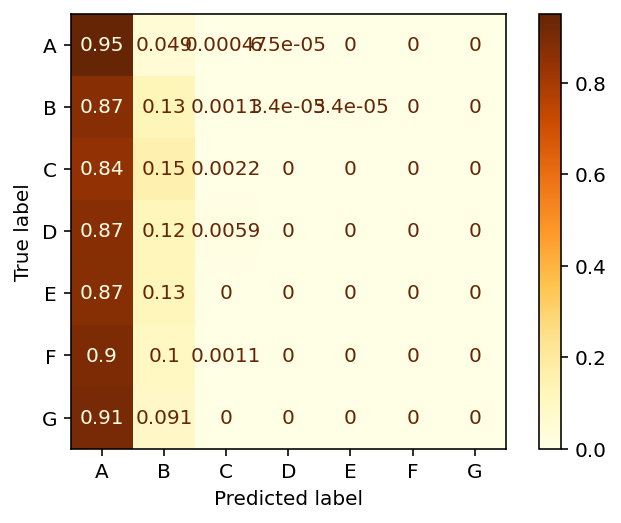

In [13]:
# Plot random forest confusion matrix
plot_confusion_matrix(rf, X_test, y_test, cmap = 'YlOrBr', normalize= 'true');

## More Advanced Random Forest Classifier

In [14]:
# instantiate Validation Curve to evaluate estimators of the models
num_est=[100, 200, 300]
train_scoreNum, test_scoreNum = validation_curve(
                                RandomForestClassifier(),
                                X = X_train, y = y_train, 
                                param_name = 'n_estimators', 
                                param_range = num_est, cv = 3,
                                n_jobs=-1)

In [15]:
# Instantiate Random Forest Classifier 
forestVC = RandomForestClassifier(random_state = 1,
                                  n_estimators = 750,
                                  max_depth = 15, 
                                  min_samples_split = 5,  
                                  min_samples_leaf = 1, 
                                  n_jobs=-1) 
modelVC = forestVC.fit(X_train, y_train) 
y_predVC = modelVC.predict(X_test)

In [16]:
# Set up parameters to grid search over
n_estimators = [100, 300, 500]
max_depth = [5, 8, 15, 25, 30]
min_samples_split = [2, 5, 10, 15, 50]
min_samples_leaf = [1, 2, 5, 10] 

hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf)

gridF = GridSearchCV(rf, hyperF, cv = 3, verbose = 1, 
                      n_jobs = -1)
bestF = gridF.fit(X_train, y_train)

Fitting 3 folds for each of 300 candidates, totalling 900 fits


In [17]:
# List best features score
bestF.best_score_

0.6221725626342638

In [19]:
# List best parameters
bestF.best_params_

{'max_depth': 15,
 'min_samples_leaf': 10,
 'min_samples_split': 50,
 'n_estimators': 500}

In [20]:
# Run the model with the best params from the grid search
forestOpt = RandomForestClassifier(random_state = 11, max_depth = 15, n_estimators = 100, min_samples_split = 10, min_samples_leaf = 10, n_jobs=-1)                             
modelOpt = forestOpt.fit(X_train, y_train)
y_pred = modelOpt.predict(X_test)

In [21]:
# List recall score
recall_score(y_train, modelOpt.predict(X_train), average = 'weighted')

0.6255644898474962

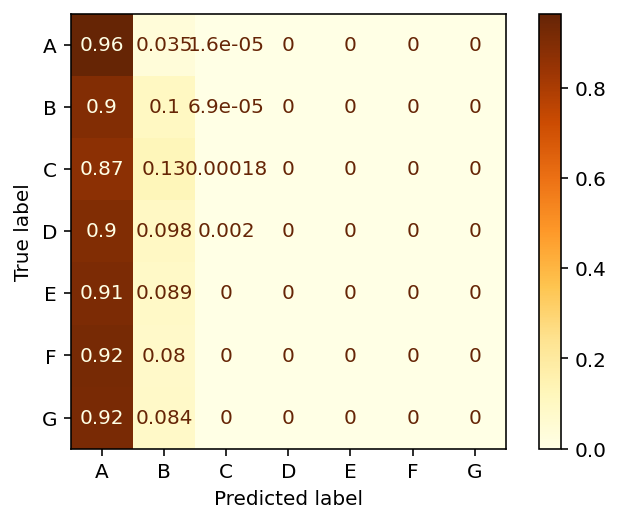

In [22]:
# Plot a confusion matrix
plot_confusion_matrix(modelOpt, X_test, y_test, cmap = 'YlOrBr', normalize= 'true');